<a href="https://colab.research.google.com/github/r7sy/SuttonBarto-RL2018-Sols/blob/master/Chapter%2002/10_armed_testbed_Multi_armed_bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The 10-armed Testbed
This notebook recreates figure 2.2 from "Reinforcement Learning an Introduction second edition" by Richard S. Sutton and Andrew G. Barto. It also contains the solution to exercise 2.5 ; The testbed is defined in the book as follows:
>To roughly assess the relative effectiveness of the greedy and $\epsilon$-greedy action-value
methods, we compared them numerically on a suite of test problems. This was a set
of 2000 randomly generated k-armed bandit problems with $k = 10$. For each bandit
problem, the action values, $q_*(a)$, a = 1,..., 10,were selected according to a normal (Gaussian) distribution with mean 0 and variance 1.
Then, when a learning method applied to that problem selected action $A_t$ at time step $t$,
the actual reward, $R_t$, was selected from a normal distribution with mean $q_*(A_t)$ and
variance 1.We call this suite of test tasks the 10-armed testbed. For any learning method, we can measure its performance and behavior as it improves with experience over 1000 time steps when applied to one of the bandit problems. This makes up one run. Repeating this for 2000 independent runs, each with a different bandit problem, we obtained measures of the learning algorithm’s average behavior.

The notebook contains the incremental implementation of the  epsilon greedy exploration scheme as described on page 32 of the book. At first we recreate figure 2.2 from the book, afterwards we use the same implementation but with a constant step size $\alpha$ to solve exercise 2.7

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

In [0]:
def getKArmedBandit(k=10,mean_reward=0.0,reward_variance=1.0):
  """ Generates q values for a k-armed bandit, using a normal distribution
      defined by mean_reward and reward_variance.
      
  Parameters
  ----------
  k : number of possible actions.
  mean_reward : mean of the normal distribution to draw action values from.
  reward_variance : variance of the normal distribution to draw action values
                    from.
  """
    return np.random.normal(loc=mean_reward,scale=reward_variance,size=k)

def epsilonGreedy(q_values,epsilon):
  """ Returns what action to take using an epsilon-greedy policy.
  The function returns the index of the chosen action, the function chooses the 
  optimal action with probability 1-epsilon+ epsilon/k where k is the number of
  actions, each non optimal action is chosen with probability epsilon/k, the
  optimal action is the action that has the highest value in the array q_values.
  
  Parameters
  ----------
  q_values : array containing the estimated value for each action.
  epsilon : probability of exploration.
 
  """
    if np.random.uniform(0,1)>epsilon:
        return np.argmax(q_values)
    return rand.randint(0,len(q_values)-1)
  
def getReward(mean,variance=1.0):
  """ Samples a reward from a normal distribution specified by mean and variance.
  """
    return rand.normalvariate(mean,variance)
  
def updateBandit(q_values,update_mean=0,update_variance=0.01):
  """ Adds to each q_value an increment sampled from a normal distribution.
  """
    return q_values+np.random.normal(update_mean,update_variance,len(q_values))
  
def runBanditProblem(q_values,epsilon=0.1,timesteps=10000,alpha=None,nonstationary=False):
  """ Runs the specified bandit problem for a number of timesteps while keeping
      estimates of the action_values denoted here as Q_values, and also
      maintaining the received rewards and occurrences of the optimal action
      across timesteps.
      
  Parameters
  ----------
  q_values : array containing the true action values the bandit problem.
  epsilon : probability of exploration.
  timesteps : number of time steps.
  alpha : step size used during updates, if none 1/n is used where n is the
          number of occurrences of the current action.
  nonstationary: specifies whether to change the q_values every timestep.
  """
    rewards=np.zeros(shape=(timesteps,))
    Q_values=np.zeros(shape=q_values.shape)
    if alpha is None:
        n=np.zeros(shape=q_values.shape)
   
    optimal_action_occurrences=np.zeros(timesteps)
    
    for timestep in range(timesteps):
        if nonstationary:
            q_values=updateBandit(q_values)
        optimal_action=np.argmax(q_values)
        action=epsilonGreedy(Q_values,epsilon)
        if action==optimal_action:
            optimal_action_occurrences[timestep]=1
       
        rewards[timestep]=getReward(q_values[action])
        
        if alpha is None:
            n[action]+=1
            Q_values[action]+=(1/n[action])*(rewards[timestep]-Q_values[action])
        else:
           
            Q_values[action]+=alpha*(rewards[timestep]-Q_values[action])
  
    return rewards,optimal_action_occurrences

In [0]:
def runTrials(epsilons=[0.1],alphas=[None],runs=1000,timesteps=1000,nonstationary=False):
  """ Generates and runs a different bandit problem for the specified number of
      trials and timesteps for every combination of the specified values for 
      epsilon and alpha,keeps averages of the rewards received and the percentage
      of choosing the optimal action in each timestep across all
      trials.
      
  Parameters
  ----------
  epsilons : list of epsilon values to run trials for.
  alphas : list of alpha values to run trials for.
  runs : number of trials for each combination of alpha and epsilon.
  timesteps : number of time steps.
  nonstationary: specifies whether to change the q_values every timestep.
  """   
    reward_averages=np.zeros(shape=(len(epsilons),len(alphas),timesteps))
    percentage_averages=np.zeros(shape=(len(epsilons),len(alphas),timesteps))
    for i,epsilon in enumerate(epsilons):
        for j,alpha in enumerate(alphas):
            rewards=np.zeros([runs,timesteps])
            percentages=np.zeros([runs,timesteps])
            for k in range(runs):
                if nonstationary:
                    q_values=np.ones(10)
                    
                else:
                    q_values=getKArmedBandit(10)
                
                
                rewards[k,:],percentages[k,:]=runBanditProblem(q_values,epsilon=epsilon,
                                                               alpha=alpha,timesteps=timesteps,nonstationary=nonstationary)

            reward_averages[i,j,:]=np.average(rewards,axis=0)
            percentage_averages[i,j,:]=np.sum(percentages,axis=0)/runs
    return reward_averages,percentage_averages

def visualizeRewardAverages(reward_averages,epsilons,alphas):
    for i,epsilon in enumerate(epsilons):
        for j,alpha in enumerate(alphas):
            plt.plot(range(timesteps),reward_averages[i,j,:],
                     label="Epsilon={} , Alpha={}".format(epsilon,[alpha if alpha is not None else "1/N"]))
           
    plt.xlabel("Timestep")
    plt.ylabel("Average reward")
    plt.legend()
    plt.show()
    
def visualizepercentageAverages(percentage_averages,epsilons,alphas):
    for i,epsilon in enumerate(epsilons):
        for j,alpha in enumerate(alphas):
            plt.plot(range(timesteps),percentage_averages[i,j,:],
                     label="Epsilon={} , Alpha={}".format(epsilon,[alpha if alpha is not None else "1/N"]))
            
    plt.xlabel("Timestep")
    plt.ylabel("% Optimal Action")
    plt.legend()
    plt.show()

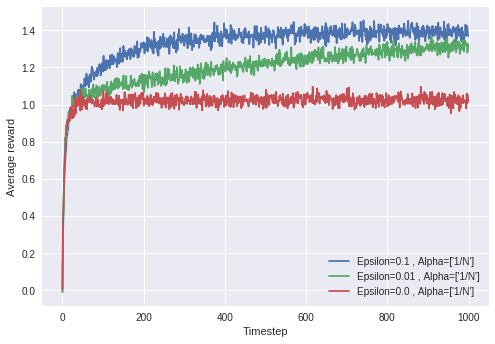

In [4]:
runs=2000
timesteps=1000
epsilons=[0.1,0.01,0.0]
alphas=[None]
reward_averages,percentage_averages=runTrials(epsilons,alphas,runs,timesteps,nonstationary=False)
visualizeRewardAverages(reward_averages,epsilons,alphas)

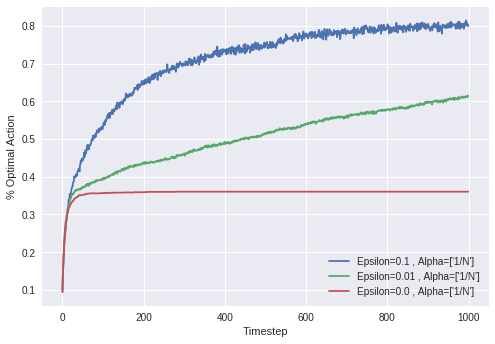

In [5]:
visualizepercentageAverages(percentage_averages,epsilons,alphas)

The following cells contain the solution to exercise 2.5 from the book:
>*Exercise 2.5 (programming)* Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, $\alpha= 0.1$. Use
$\epsilon= 0.1$ and longer runs, say of 10,000 steps.

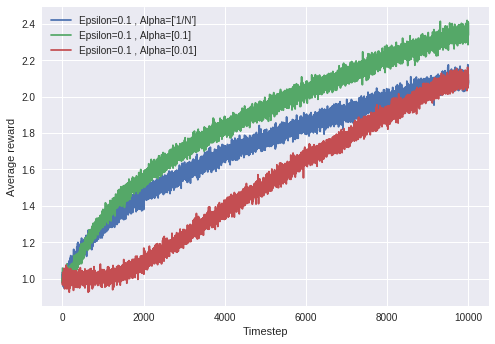

In [6]:
runs=2000
timesteps=10000
epsilons=[0.1]
alphas=[None,0.1,0.01]
reward_averages,percentage_averages=runTrials(epsilons,alphas,runs,timesteps,nonstationary=True)
visualizeRewardAverages(reward_averages,epsilons,alphas)

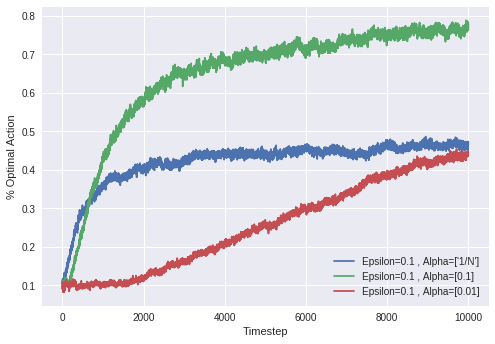

In [7]:
visualizepercentageAverages(percentage_averages,epsilons,alphas)

It is clear in the generated figures that the sample-average method struggles to keep up with the nonstationarity of the problem, whereas a constant step-size value of $\alpha=0.1$ performs much better. The figure indicates that even a small value of $alpha=0.01$ can in the long run outperform the sample-average method for nonstationary tasks. 